In [2]:
import copy
import json
import pickle

import gym
from gym_minigrid.minigrid import Grid
from gym_minigrid.wrappers import FullyObsWrapper, ReseedWrapper, RGBImgObsWrapper
import matplotlib.pylab as plt
import networkx as nx
import numpy as np
from PIL import Image
import pytorch_ssim
import seaborn as sns
import sklearn
from skimage.transform import resize, rescale, downscale_local_mean
from skimage.util import img_as_ubyte
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
import torch.nn as nn

from rlpyt.models.dqn.dsr.idf_model import IDFModel
from rlpyt.envs.gym import make as gym_make
from rlpyt.utils.seed import set_seed
from gym_minigrid.envs.multiroom import MultiRoomEnv

In [8]:
from collections import defaultdict

In [12]:
','.join(map(str, [0]))

'0'

In [3]:
A = np.array([[0, 1, 0.5],
              [1, 0, 0.3],
              [0.5, 0.3, 0]])

In [4]:
G = nx.from_numpy_array(A)

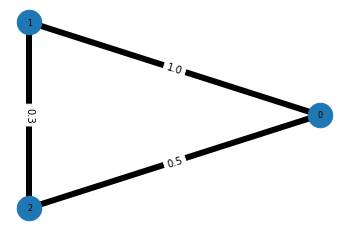

In [6]:
pos = nx.circular_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=600)

# edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges,
                       width=6)

labels=nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')
nx.draw_networkx_edge_labels(G, pos, font_size=10, font_family='sans-serif', edge_labels=labels)
plt.axis('off')
plt.savefig("test.png", dpi=1000)

In [7]:
nx.shortest_path(G, 0, 1, weight='weight')

[0, 2, 1]

In [90]:
predecessors, distance = nx.floyd_warshall_predecessor_and_distance(G)

In [91]:
nx.is_connected(G)

False

In [92]:
nx.to_numpy_array(G)

array([[0. , 0. , 0.5],
       [0. , 0. , 0. ],
       [0.5, 0. , 0. ]])

In [50]:
np.array(list(path))

array([[0, {0: [0], 1: [0, 1], 2: [0, 2]}],
       [1, {1: [1], 0: [1, 0], 2: [1, 0, 2]}],
       [2, {2: [2], 0: [2, 0], 1: [2, 0, 1]}]], dtype=object)

KeyError: 'a'

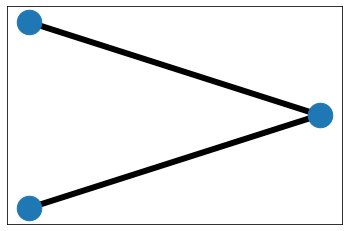

In [7]:
G = nx.Graph()

G.add_edge('a', 'b', weight=0.6)
G.add_edge('a', 'c', weight=0.2)
G.add_edge('c', 'd', weight=0.1)
G.add_edge('c', 'e', weight=0.7)
G.add_edge('c', 'f', weight=0.9)
G.add_edge('a', 'd', weight=0.3)


pos = nx.circular_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=600)

# edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges,
                       width=6)

# labels
names = {'a': '1, 1',
         'b': '2, 3',
         'c': '3, 4',
         'd': '23, 23'}

labels=nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif', labels=names)
nx.draw_networkx_edge_labels(G, pos, font_size=10, font_family='sans-serif', edge_labels=labels)
plt.axis('off')
plt.savefig("test.png", dpi=1000)

In [73]:
A = np.random.randn(5, 3)

In [95]:
A = np.random.randint(0, 100, size=(25, 25))

In [96]:
from scipy.stats import entropy

In [103]:
entropy([0, 0, 1], base=2)

0.0

In [74]:
A[0, 0]

0.745656102459472

In [97]:
A = torch.rand((5, 5)) - 0.5
A  = A / torch.norm(A, p=2, dim=1, keepdim=True)

In [98]:
A[range(5), range(5)] = -2

In [99]:
A

tensor([[-2.0000,  0.1409, -0.3140, -0.5139,  0.4142],
        [ 0.4233, -2.0000,  0.4062, -0.3309,  0.6827],
        [-0.6344, -0.6352, -2.0000, -0.0607,  0.0521],
        [-0.6459,  0.0370,  0.0998, -2.0000, -0.6593],
        [ 0.5384,  0.3502,  0.2431, -0.1703, -2.0000]])

In [100]:
max_idx = A.argmax(dim=1)
max_idx

tensor([4, 4, 4, 2, 0])

In [102]:
non_edges = A < 0.4
non_edges

tensor([[ True,  True,  True,  True, False],
        [False,  True, False,  True, False],
        [ True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True],
        [False,  True,  True,  True,  True]])

In [105]:
non_edges[range(5), max_idx] = False
non_edges

tensor([[ True,  True,  True,  True, False],
        [False,  True, False,  True, False],
        [ True,  True,  True,  True, False],
        [ True,  True, False,  True,  True],
        [False,  True,  True,  True,  True]])

In [106]:
A[non_edges] = np.nan

In [109]:
print(A)
A = A.detach().cpu().numpy()

tensor([[   nan,    nan,    nan,    nan, 0.4142],
        [0.4233,    nan, 0.4062,    nan, 0.6827],
        [   nan,    nan,    nan,    nan, 0.0521],
        [   nan,    nan, 0.0998,    nan,    nan],
        [0.5384,    nan,    nan,    nan,    nan]])


In [110]:
np.isnan(A[0, 0])

True

In [77]:
A[range(len(A) - 1)]

tensor([[ 0.6404,  0.6760, -0.3644],
        [ 0.3595, -0.1969, -0.9121],
        [-0.5809, -0.0310,  0.8133],
        [-0.6829, -0.3696, -0.6302]])

In [5]:
mode = 'multiroom'
minigrid_config = {'size': [25, 25], 'epsilon': 0.5}
env_id=None
set_seed(333)

env = gym_make(id=env_id, mode=mode, minigrid_config=minigrid_config)
obs = env.reset()
# plt.imshow(obs[:, :, 0] - obs[:, :, 1])
# plt.colorbar()

using seed 333


In [6]:
env.goal_pos

array([15, 19])

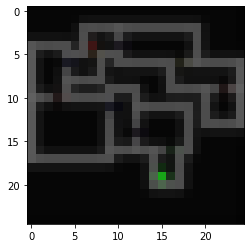

In [5]:
plt.imshow(obs)

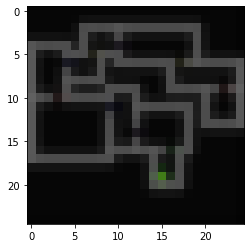

In [6]:
plt.imshow(env.get_goal_state())

In [ ]:
plt.imshow(obs)

In [ ]:
pos = tuple(env.agent_pos)
pos

In [ ]:
idx = (obs[:, :, 0] - obs[:, :, 1]).argmax()

In [ ]:
agent_pos = idx // 25, idx % 25

In [ ]:
A = np.zeros((25, 25))

In [ ]:
A[agent_pos] = 1

In [ ]:
obs[agent_pos] = (1, 1, 1)
plt.imshow(obs)

### Successor Features Heatmap

In [ ]:
def generate_dsr_grid(sr_matrix, starting_pos=(1, 8)):
    starting_sr = sr_matrix[starting_pos]
    
    side_size = sr_matrix.shape[0]
    
    grid = np.zeros((side_size, side_size))
    for x in range(side_size):
        for y in range(side_size):
            grid[x, y] = np.linalg.norm(sr_matrix[x, y] - starting_sr, 2)
    return grid


def visualize_dsr(sr_source, starting_pos=(1, 8), direction=-1, action=-1, normalize=True):
    if isinstance(sr_source, str):
        if 'pt' in sr_source:
            sr = torch.load(sr_source)
            sr = sr.detach().numpy()
        else:
            sr = np.load(sr_source)
    else:
        sr = sr_source

    if direction == -1:
        sr_matrix = sr.mean(axis=2)
        
    else:
        sr_matrix = sr[:, :, direction]

    if action == -1:
        sr_matrix = sr_matrix.mean(axis=2)
    else:
        sr_matrix = sr_matrix[:, :, action]
    
    side_size = sr_matrix.shape[0]
    
    if normalize:
        sr_matrix = sr_matrix.reshape(side_size ** 2, -1)
        sr_matrix = (sr_matrix - np.nanmean(sr_matrix, axis=0)) / np.nanstd(sr_matrix, axis=0)
        sr_matrix = sr_matrix.reshape(side_size, side_size, -1)
#         sr_matrix = sr_matrix / np.linalg.norm(sr_matrix, axis=2).reshape(side_size, side_size, -1)
    grid = generate_dsr_grid(sr_matrix, starting_pos)
    return sr_matrix, grid


In [ ]:
dsr, dsr_heatmap = visualize_dsr('../experiments/successor-data/20200411-run0-100k.pt', (14, 4), -1, -1, True)
figure = plt.figure(figsize=(10, 10))
plt.imshow(dsr_heatmap.T)
plt.colorbar()

### Subgoal Q-Values

In [ ]:
from sklearn_extra.cluster import KMedoids

In [ ]:
config_file = '../data/local/20200411/multiroom/run_0/params.json'
with open(config_file, 'r') as f:
    config = json.load(f)

In [ ]:
mode = config['mode']
seed = config['seed']
set_seed(seed)

device = torch.device('cuda', index=0)

In [ ]:
checkpoint = '../data/local/20200411/multiroom/run_0/itr_99999.pkl'

In [ ]:
params = torch.load(checkpoint, map_location=device)

In [ ]:
ENV_ID = 'MiniGrid-FourRooms-v0'
env = gym_make(id=ENV_ID, mode=mode, minigrid_config=config['env'])
obs = env.reset()

In [ ]:
feature_model = IDFModel(env.observation_space.shape, env.action_space.n, **config['agent']['idf_model_kwargs'])
feature_model.load_state_dict(params['agent_state_dict']['idf_model'])
feature_model.to(device)

In [ ]:
dsr = torch.load('../experiments/successor-data/20200411-run0-100k.pt').detach().numpy()
action_dsr = dsr.mean(axis=2)  # normalize direction dimension
normed_dsr = action_dsr / np.linalg.norm(action_dsr, ord=2, axis=3, keepdims=True)

### Find Landmarks

In [ ]:
state_dsr = action_dsr.mean(axis=2)

In [ ]:
raw_s_features = state_dsr.reshape(25 * 25, 64)

In [ ]:
walls = np.isnan(raw_s_features).any(axis=1)
s_features = raw_s_features[~walls]

In [ ]:
indices = np.array(list(itertools.product(range(25), range(25))))

In [ ]:
kmedoids = KMedoids(n_clusters=8, random_state=seed).fit(s_features)
landmarks = kmedoids.medoid_indices_
landmark_states = indices[~walls][landmarks]
landmark_states

In [ ]:
landmark_map = walls.astype(int).reshape(25, 25)
landmark_map[landmark_states[:, 0], landmark_states[:, 1]] = 2

In [ ]:
figure = plt.figure(figsize=(10, 10))
plt.imshow(landmark_map.T)

### Subgoal Policy

In [ ]:
subgoal = (14, 4)

In [ ]:
env.unwrapped.agent_pos = np.array(subgoal)

obs, _, _, _ = env.env.env.step(5)
obs = torch.Tensor(obs).unsqueeze(0)
features = feature_model(obs.to(device), mode='encode')
features = features.squeeze().detach().cpu().numpy()
normed_features = features / np.linalg.norm(features, ord=2)



q_values = np.dot(normed_dsr, normed_features)

In [ ]:
figure = plt.figure(figsize=(10, 10))
plt.imshow(q_values.max(axis=2).T)
for x in range(q_values.shape[0]):
    plt.axvline(x + 0.5, color='k', linestyle=':')
    for y in range(q_values.shape[1]):
        plt.axhline(y + 0.5, color='k', linestyle=':')
        
        if (x, y) == subgoal:
            circle = plt.Circle((x, y), 0.2, color='k')
            plt.gca().add_artist(circle)
        
        else:
            if any(np.isnan(q_values[x, y])):
                continue

            action = q_values[x, y].argmax()
            dx = 0
            dy = 0
            if action == 0:
                dx = 0.35
            elif action == 1:
                dy = 0.35
            elif action == 2:
                dx = -0.35
            else:
                dy = -0.35

            plt.arrow(x - dx, y - dy, dx, dy, head_width=0.3, head_length=0.3, fc='k', ec='k')
    
plt.colorbar()

### T-SNE Plots

In [ ]:
import itertools
from sklearn.manifold import TSNE

In [ ]:
dsr = torch.load('../experiments/successor-data/20200411-run0-100k.pt').detach().numpy()

In [ ]:
raw_sf = dsr.mean(axis=(2, 3))

In [ ]:
s_features = raw_sf.reshape(25 * 25, 64)
walls = np.isnan(s_features).any(axis=1)
s_features = s_features[~walls]

In [ ]:
sf_embedded = TSNE(n_components=2).fit_transform(s_features)

In [ ]:
rooms = np.zeros((25, 25))

In [ ]:
for i, room in enumerate(env.rooms, 1):
    start_x, start_y = room.top
    size_x, size_y = room.size
    for x in range(start_x + 1, start_x + size_x - 1):
        for y in range(start_y + 1, start_y + size_y - 1):
            rooms[x, y] = i

In [ ]:
rooms = rooms.reshape(25 * 25)[~walls]

In [ ]:
figure = plt.figure(figsize=(10, 10))
data = sf_embedded[rooms == 0]
plt.scatter(data[:, 0], data[:, 1], label='Doorway', marker='*')
for i in range(1, len(env.rooms) + 1):
    data = sf_embedded[rooms == i]
    plt.scatter(data[:, 0], data[:, 1], label='Room ' + str(i))
plt.legend()